In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('CensusClustering').getOrCreate()

### Data Retrieval & Preparation

In [ ]:
!wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/census1990-mld/USCensus1990.data.txt'

--2020-12-08 15:33:29--  https://archive.ics.uci.edu/ml/machine-learning-databases/census1990-mld/USCensus1990.data.txt
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 361344227 (345M) [application/x-httpd-php]
Saving to: ‘USCensus1990.data.txt’

USCensus1990.data.t 100%[===================>] 344.60M  43.7MB/s    in 8.4s    

2020-12-08 15:33:38 (41.0 MB/s) - ‘USCensus1990.data.txt’ saved [361344227/361344227]



In [ ]:
df = spark.read.csv('USCensus1990.data.txt', header = True, inferSchema=True)

In [ ]:
#df.show(10)

In [ ]:
#Variable I'm going to use
df = df.select('dAge', 'iCitizen', 'iDisabl1', 'iEnglish', 'iFertil',
          'iLang1',
          'iMeans', 'iMilitary', 'iOthrserv',
          'dPwgt1', 'dPOB', 'iClass',
          'dRpincome', 'iRspouse', 'iSchool', 'iSex',
          'iTmpabsnt', 'dTravTime', 'iWork89', 'iYearsch'
          )

#Create copy if needed later
df_vis = df
#Want -region of us, place of birth, employment status of parents

#Variable removed, maybe add back dRPOB/POB, iImmigr., rvetserv, iVietnam, iWWII, remplr

In [ ]:
df.show(5)

+----+--------+--------+--------+-------+------+------+---------+---------+------+----+------+---------+--------+-------+----+---------+---------+-------+--------+
|dAge|iCitizen|iDisabl1|iEnglish|iFertil|iLang1|iMeans|iMilitary|iOthrserv|dPwgt1|dPOB|iClass|dRpincome|iRspouse|iSchool|iSex|iTmpabsnt|dTravTime|iWork89|iYearsch|
+----+--------+--------+--------+-------+------+------+---------+---------+------+----+------+---------+--------+-------+----+---------+---------+-------+--------+
|   5|       0|       2|       1|      1|     1|     1|        4|        0|     1|   0|     5|        3|       3|      1|   1|        0|        5|      1|      11|
|   6|       0|       2|       0|      3|     2|     1|        4|        0|     2|   0|     7|        2|       1|      1|   1|        0|        1|      1|       5|
|   3|       0|       2|       0|      1|     2|    10|        4|        0|     1|   0|     7|        2|       6|      1|   1|        0|        2|      1|      10|
|   4|       0| 

In [ ]:
df.select('dTravtime').distinct().show()

+---------+
|dTravtime|
+---------+
|        1|
|        6|
|        3|
|        5|
|        4|
|        2|
|        0|
+---------+



### Figuring out One-Hot Encoding and best Variable Representations

In [ ]:
#dage -> numerical standardized, keep as is
#Avail
#from pyspark.ml.feature import OneHotEncoderEstimator

#encoder = OneHotEncoderEstimator(inputCols=['iAvail'], outputCols=['Work Availability'])
#df = encoder.fit(df).transform(df)

In [ ]:
from pyspark.ml.feature import OneHotEncoderEstimator
encoder = OneHotEncoderEstimator(inputCols=['iCitizen'], outputCols=['Citizen Status'])
df = encoder.fit(df).transform(df)

In [ ]:
encoder = OneHotEncoderEstimator(inputCols=['iDisabl1'], outputCols=['Disability Status'])
df = encoder.fit(df).transform(df)

In [ ]:
encoder = OneHotEncoderEstimator(inputCols=['iLang1'], outputCols=['Numb Lang Spke'])
df = encoder.fit(df).transform(df)

In [ ]:
encoder = OneHotEncoderEstimator(inputCols=['iClass'], outputCols=['Work Class'])
df = encoder.fit(df).transform(df)

In [ ]:
#Do something with Means of transportation encoding
encoder = OneHotEncoderEstimator(inputCols=['iMeans'], outputCols=['Means Transpo'])
df = encoder.fit(df).transform(df)

In [ ]:
#military service - 0/4 -> no, 1,2,3 -> yes
encoder = OneHotEncoderEstimator(inputCols=['iMilitary'], outputCols=['Military Status'])
df = encoder.fit(df).transform(df)

In [ ]:
#RPOB -> reduce variability
from pyspark.sql import functions as F

encoder = OneHotEncoderEstimator(inputCols=['dPOB'], outputCols=['POB'])
df = encoder.fit(df).transform(df)

In [ ]:
encoder = OneHotEncoderEstimator(inputCols=['iRspouse'], outputCols=['Spouse Status'])
df = encoder.fit(df).transform(df)

In [ ]:
encoder = OneHotEncoderEstimator(inputCols=['iSchool'], outputCols=['School Enrollment'])
df = encoder.fit(df).transform(df)

In [ ]:
#tmpabsnt, reduce
encoder = OneHotEncoderEstimator(inputCols=['iTmpabsnt'], outputCols=['Work Absnce'])
df = encoder.fit(df).transform(df)

In [ ]:
encoder = OneHotEncoderEstimator(inputCols=['iWork89'], outputCols=['Work 89'])
df = encoder.fit(df).transform(df)

In [ ]:
encoder = OneHotEncoderEstimator(inputCols=['dAge'], outputCols=['Age'])
df = encoder.fit(df).transform(df)

In [ ]:
encoder = OneHotEncoderEstimator(inputCols=['iFertil'], outputCols=['Child Numb'])
df = encoder.fit(df).transform(df)

In [ ]:
encoder = OneHotEncoderEstimator(inputCols=['dPwgt1'], outputCols=['Weight'])
df = encoder.fit(df).transform(df)

In [ ]:
encoder = OneHotEncoderEstimator(inputCols=['dRpincome'], outputCols=['Income'])
df = encoder.fit(df).transform(df)

In [ ]:
encoder = OneHotEncoderEstimator(inputCols=['dTravTime'], outputCols=['Trav Time'])
df = encoder.fit(df).transform(df)

In [ ]:
encoder = OneHotEncoderEstimator(inputCols=['iYearsch'], outputCols=['SchYr'])
df = encoder.fit(df).transform(df)

In [ ]:
encoder = OneHotEncoderEstimator(inputCols=['iEnglish'], outputCols=['Eng'])
df = encoder.fit(df).transform(df)

### Data Selection after One-Hot Encoding

In [ ]:
df1 = df.select('Age', 'Citizen Status', 'Disability Status', 'Eng',
                'Child Numb', 'Numb Lang Spke', 'Means Transpo', 'Military Status',
                'Weight', 'Income', 'Spouse Status', 'Work Class',
                'School Enrollment', 'Work Absnce', 'Trav Time', 'Work 89',
                'SchYr', 'POB','iSex', #variables for later use on line below, add sex
                'dAge', 'iCitizen', 'iDisabl1', 'iEnglish','iFertil', 'iLang1', 'iMeans', 'iMilitary','dPwgt1',
                'dRpincome','iRspouse','iClass','iSchool','iTmpabsnt', 'dPOB','iWork89',
                'dTravTime', 'iYearsch')

In [ ]:
df1.show(3)

+-------------+--------------+-----------------+-------------+--------------+--------------+---------------+---------------+-------------+-------------+-------------+-------------+-----------------+-------------+-------------+-------------+---------------+-------------+----+----+--------+--------+--------+-------+------+------+---------+------+---------+--------+------+-------+---------+----+-------+---------+--------+
|          Age|Citizen Status|Disability Status|          Eng|    Child Numb|Numb Lang Spke|  Means Transpo|Military Status|       Weight|       Income|Spouse Status|   Work Class|School Enrollment|  Work Absnce|    Trav Time|      Work 89|          SchYr|          POB|iSex|dAge|iCitizen|iDisabl1|iEnglish|iFertil|iLang1|iMeans|iMilitary|dPwgt1|dRpincome|iRspouse|iClass|iSchool|iTmpabsnt|dPOB|iWork89|dTravTime|iYearsch|
+-------------+--------------+-----------------+-------------+--------------+--------------+---------------+---------------+-------------+-------------+--

In [ ]:
df1.columns[0:19]

['Age',
 'Citizen Status',
 'Disability Status',
 'Eng',
 'Child Numb',
 'Numb Lang Spke',
 'Means Transpo',
 'Military Status',
 'Weight',
 'Income',
 'Spouse Status',
 'Work Class',
 'School Enrollment',
 'Work Absnce',
 'Trav Time',
 'Work 89',
 'SchYr',
 'POB',
 'iSex']

### Correlation Matrix to help Analyze Variable for Data Dimensionality Reduction

In [ ]:
#import pandas as pd

In [ ]:
#dfp = pd.read_csv('USCensus1990.data.txt')

In [ ]:
"""dfp = dfp[['dAge', 'iAvail', 'iCitizen', 'iDisabl1', 'iDisabl2', 'iEnglish', 'iFertil', 'dHispanic', 'dHour89', 'iImmigr',
          'dIncome1', 'dIncome2', 'dIncome3', 'dIncome4', 'dIncome5', 'dIncome6', 'dIncome7', 'dIncome8', 'iLang1', 'iLooking', 'iMarital',
          'iMeans', 'iMilitary', 'iMobillim', 'dOccup', 'iOthrserv', 'iPerscare', 'dPOB', 
          'dPoverty', 'dPwgt1', 'dRearning', 'iRelat1', 'iRelat2', 'iRemplpar', 'iRlabor', 
          'dRpincome', 'iRPOB', 'iRspouse', 'iRvetserv', 'iSchool', 'iSex',
          'iTmpabsnt', 'dTravtime', 'iVietnam', 'dWeek89', 'iWork89', 'iWWII', 'iYearsch',
          'dYrsserv']]"""

"dfp = dfp[['dAge', 'iAvail', 'iCitizen', 'iDisabl1', 'iDisabl2', 'iEnglish', 'iFertil', 'dHispanic', 'dHour89', 'iImmigr',\n          'dIncome1', 'dIncome2', 'dIncome3', 'dIncome4', 'dIncome5', 'dIncome6', 'dIncome7', 'dIncome8', 'iLang1', 'iLooking', 'iMarital',\n          'iMeans', 'iMilitary', 'iMobillim', 'dOccup', 'iOthrserv', 'iPerscare', 'dPOB', \n          'dPoverty', 'dPwgt1', 'dRearning', 'iRelat1', 'iRelat2', 'iRemplpar', 'iRlabor', \n          'dRpincome', 'iRPOB', 'iRspouse', 'iRvetserv', 'iSchool', 'iSex',\n          'iTmpabsnt', 'dTravtime', 'iVietnam', 'dWeek89', 'iWork89', 'iWWII', 'iYearsch',\n          'dYrsserv']]"

In [ ]:
#dfp.head()

In [ ]:
#dfp.corr().to_csv('VarCorrs.csv')

In [ ]:
#from google.colab import files
#files.download("VarCorrs.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Exploratory Analysis

In [ ]:
df_quant = df1.select('dAge', 'iFertil', 'dPwgt1', 'dRearning', 'dRpincome', 'dTravTime', 'iYearsch')     

dfquant2 = df_quant.withColumnRenamed("dAge","Age") \
    .withColumnRenamed("iFertil","Numb Children") \
    .withColumnRenamed("dPwgt1","Weight") \
    .withColumnRenamed("dRpincome","Personal Income") \
    .withColumnRenamed("iYearsch","Year in School")

dfquant2.summary().show()

AnalysisException: ignored

In [ ]:
#Need a df for visualizations w/o one hot encoding
import pandas as pd

#Create pandas version
df_visp = df_vis.toPandas()

KeyboardInterrupt: ignored

In [ ]:
df_visp.head()

In [ ]:
df_visp.hist(column='iWork89', grid = False, xlabelsize = 14, ylabelsize = 14)

#import matplotlib.pyplot as plt
#import numpy as np

#plt.hist(df_visp['iMilitary'], density=True, bins=10)  # `density=False` would make counts
#plt.ylabel('Probability')
#plt.xlabel('Data');

### K Means Clustering and Cluster Amount Selection

In [ ]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=df1.columns[0:19],outputCol="features")
df1 = assembler.transform(df1)
df1.show()

+-------------+--------------+-----------------+-------------+--------------+--------------+---------------+---------------+-------------+-------------+-------------+-------------+-----------------+-------------+-------------+-------------+---------------+-------------+----+----+--------+--------+--------+-------+------+------+---------+------+---------+--------+------+-------+---------+----+-------+---------+--------+--------------------+
|          Age|Citizen Status|Disability Status|          Eng|    Child Numb|Numb Lang Spke|  Means Transpo|Military Status|       Weight|       Income|Spouse Status|   Work Class|School Enrollment|  Work Absnce|    Trav Time|      Work 89|          SchYr|          POB|iSex|dAge|iCitizen|iDisabl1|iEnglish|iFertil|iLang1|iMeans|iMilitary|dPwgt1|dRpincome|iRspouse|iClass|iSchool|iTmpabsnt|dPOB|iWork89|dTravTime|iYearsch|            features|
+-------------+--------------+-----------------+-------------+--------------+--------------+---------------+----

In [ ]:
#final model, k= 3, 4, or 5, sticking with 3
from pyspark.ml.clustering import KMeans
kmeans = KMeans(k=3)
model = kmeans.fit(df1)

In [ ]:
predicted = model.transform(df1)
predicted.show(3)

+-------------+--------------+-----------------+-------------+--------------+--------------+---------------+---------------+-------------+-------------+-------------+-------------+-----------------+-------------+-------------+-------------+---------------+-------------+----+----+--------+--------+--------+-------+------+------+---------+------+---------+--------+------+-------+---------+----+-------+---------+--------+--------------------+----------+
|          Age|Citizen Status|Disability Status|          Eng|    Child Numb|Numb Lang Spke|  Means Transpo|Military Status|       Weight|       Income|Spouse Status|   Work Class|School Enrollment|  Work Absnce|    Trav Time|      Work 89|          SchYr|          POB|iSex|dAge|iCitizen|iDisabl1|iEnglish|iFertil|iLang1|iMeans|iMilitary|dPwgt1|dRpincome|iRspouse|iClass|iSchool|iTmpabsnt|dPOB|iWork89|dTravTime|iYearsch|            features|prediction|
+-------------+--------------+-----------------+-------------+--------------+-------------

In [ ]:
#Visualizing the Model

In [ ]:
centers = model.clusterCenters()
#print(centers)
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predicted)
print(silhouette)

0.34283075293362036


### Evaluating k selection

In [ ]:
#cost = model.computeCost(df1)
#print(cost)

In [ ]:
#import matplotlib.pyplot as plt
#costs = []
#for k in range(11,15):
#  model = KMeans(k=k).fit(df1)
#  costs.append(model.computeCost(df1))

#plt.plot(range(11,15), costs)

In [ ]:
#from pyspark.ml.evaluation import ClusteringEvaluator
#evaluator = ClusteringEvaluator()
#silhouette = evaluator.evaluate(predicted)
#print(silhouette)

In [ ]:
#silhouettes = []
#for k in range(11, 15):
#  predicted = KMeans(k=k).fit(df1).transform(df1)
#  silhouettes.append(evaluator.evaluate(predicted))

#plt.plot(range(11,15), silhouettes)

In [ ]:
#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
#axes[0].plot(range(2,10), costs)
#axes[0].title.set_text('Cost vs k')
#axes[1].plot(range(2,10), silhouettes)
#axes[1].title.set_text('Silhouette vs k')

### Hierarchical Clustering

In [ ]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [ ]:
bkm = BisectingKMeans().setK(8).setSeed(1)
h_model = bkm.fit(df1)

In [ ]:
predictions = h_model.transform(df1)

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(silhouette)

0.21634012305674494


In [ ]:
silhouette_h1 = []

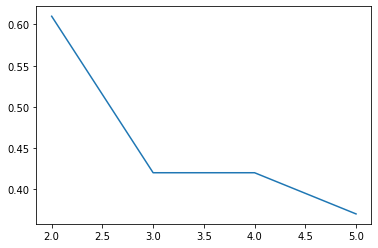

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(2,6), silhouette_h1)

###  Visualizing The final Model Results

In [ ]:
cols = predicted.columns[18:39]
cols

['iSex',
 'dAge',
 'iCitizen',
 'iDisabl1',
 'iEnglish',
 'iFertil',
 'iLang1',
 'iMeans',
 'iMilitary',
 'dPwgt1',
 'dRpincome',
 'iRspouse',
 'iClass',
 'iSchool',
 'iTmpabsnt',
 'dPOB',
 'iWork89',
 'dTravTime',
 'iYearsch',
 'features',
 'prediction']

In [ ]:
pdf = predicted.select(cols)
pdf = pdf.drop('features')
pdf.show(5)

+----+----+--------+--------+--------+-------+------+------+---------+------+---------+--------+------+-------+---------+----+-------+---------+--------+----------+
|iSex|dAge|iCitizen|iDisabl1|iEnglish|iFertil|iLang1|iMeans|iMilitary|dPwgt1|dRpincome|iRspouse|iClass|iSchool|iTmpabsnt|dPOB|iWork89|dTravTime|iYearsch|prediction|
+----+----+--------+--------+--------+-------+------+------+---------+------+---------+--------+------+-------+---------+----+-------+---------+--------+----------+
|   1|   5|       0|       2|       1|      1|     1|     1|        4|     1|        3|       3|     5|      1|        0|   0|      1|        5|      11|         2|
|   1|   6|       0|       2|       0|      3|     2|     1|        4|     2|        2|       1|     7|      1|        0|   0|      1|        1|       5|         2|
|   1|   3|       0|       2|       0|      1|     2|    10|        4|     1|        2|       6|     7|      1|        0|   0|      1|        2|      10|         2|
|   1|   4

In [ ]:
import pandas as pd
pdf = pdf.toPandas()

In [ ]:
pdf.head(2)

,iSex,dAge,iCitizen,iDisabl1,iEnglish,iFertil,iLang1,iMeans,iMilitary,dPwgt1,dRpincome,iRspouse,iClass,iSchool,iTmpabsnt,dPOB,iWork89,dTravTime,iYearsch,prediction
0,1,5,0,2,1,1,1,1,4,1,3,3,5,1,0,0,1,5,11,2
1,1,6,0,2,0,3,2,1,4,2,2,1,7,1,0,0,1,1,5,2


In [ ]:
pdf0 = pdf[pdf.prediction == 0]
pdf1 = pdf[pdf.prediction == 1]
pdf2 = pdf[pdf.prediction == 2]

In [ ]:
#Cluster Sizes
print("cluster1 size:", len(pdf0))
print("cluster2 size:", len(pdf1))
print("cluster3 size:", len(pdf2))

cluster1 size: 574468
cluster2 size: 771305
cluster3 size: 1112512


In [ ]:
pdf1.head(3)

,iSex,dAge,iCitizen,iDisabl1,iEnglish,iFertil,iLang1,iMeans,iMilitary,dPwgt1,dRpincome,iRspouse,iClass,iSchool,iTmpabsnt,dPOB,iWork89,dTravTime,iYearsch,prediction
4,1,7,0,2,0,3,2,0,4,1,2,1,0,1,3,0,2,0,5,1
8,1,6,0,2,0,7,2,0,4,1,2,1,1,1,3,0,1,0,10,1
9,0,3,0,2,0,0,2,0,2,1,2,6,1,1,1,0,1,0,8,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89a3f58f60>]],
      dtype=object)

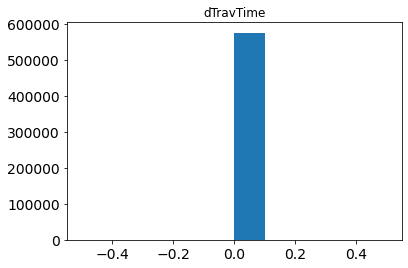

In [ ]:
col_int = 'dTravTime'
pdf0.hist(column=col_int, grid = False, xlabelsize = 14, ylabelsize = 14)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89a3f0f438>]],
      dtype=object)

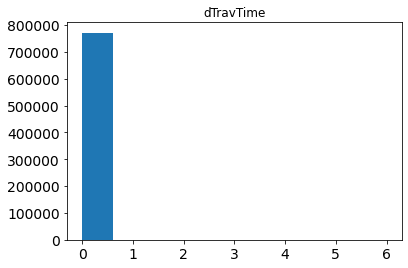

In [ ]:
pdf1.hist(column=col_int, grid = False, xlabelsize = 14, ylabelsize = 14)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89a3e8b898>]],
      dtype=object)

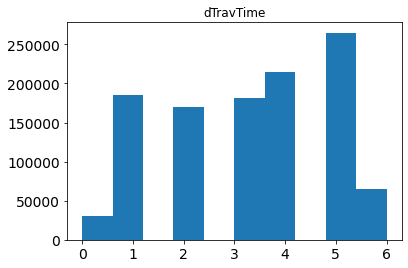

In [ ]:
pdf2.hist(column=col_int, grid = False, xlabelsize = 14, ylabelsize = 14)

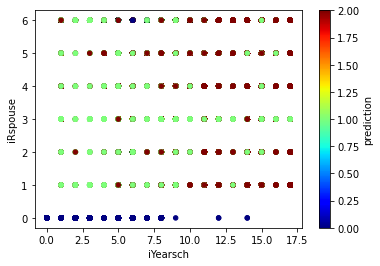

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
#test_df.plot(kind="scatter", x="X", y="Y", s=50, c="C", cmap="plasma", ax=ax);
pdf.plot.scatter(x='iYearsch',
                 y='iRspouse',
                 c='prediction',
                 colormap='jet',
                 ax = ax
                )

### Dendrogram